In [1]:
import os
import subprocess
import sys
sys.path.insert(1, os.path.abspath('../tools'))
import time
import numpy as np
from scipy.interpolate import interp1d
import zipfile
import pylhe
from scipy.interpolate import make_interp_spline
from AnalysisMG5 import Analysis
from decayChainAnalytic import getAvgGammaBeta
from decayChainAnalytic import getDecayGammaBeta
from decayChainAnalytic import velocity
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import json 
import seaborn as sns

#plotting options
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

plt.rcParams.update({"savefig.dpi" : 300}) #Figure resolution
plt.rcParams['figure.figsize'] = (8,7)


#Define plotting style:
sns.set() #Set style
sns.set_style('ticks',{'font.family':'Times New Roman', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=2.0)
cm = plt.cm.get_cmap('RdYlBu')

### Define labels for distinct processes

In [2]:

processLatexLabels = {'gluino_2body' : r'$pp \to \tilde g + \tilde g, \tilde g \to \tilde u u$',
                'chargino_2bodyE' : r'$pp \to \tilde \chi_1^+ + \tilde \chi_1^-, \tilde \chi_1^\pm \to \tilde e^\pm \nu$',
                'selectron_2body' : r'$pp \to \tilde e^+ + \tilde e^-, \tilde e^\pm \to \tilde \chi_1^0 e^\pm$',
                'gluino_3body' : r'$pp \to \tilde g + \tilde g, \tilde g \to \tilde \chi_1^0 u u$',
                'squark_2body' : r'$pp \to \tilde u + \tilde u, \tilde y \to \tilde \chi_1^0 u$',
                'chargino_2bodyW' : r'$pp \to \tilde \chi_1^+ + \tilde \chi_1^-, \tilde \chi_1^\pm \to \tilde \chi_1^0 W^\pm$',
                'gluino_2step' : r'$pp \to \tilde g + \tilde g, \tilde g \to \tilde u u, \tilde u \to \tilde \chi_1^0 u$',
                'higgs_2step' : r'$pp \to H^+ + H^-, H^\pm \to H^0 W^\pm, H^0 \to h Z$'}

processShortLabels = {'GammaBeta_2C_n30000.dat' : 'gluino_2body',
                'GammaBeta_spinhalf_n20000.dat' : 'chargino_2bodyE',
                'GammaBeta_spin0_Analise.dat' : 'selectron_2body',
                'GammaBeta_3C_Analise.dat' : 'gluino_3body',
                'GammaBeta_T-chanel_n10000.dat' : 'squark_2body',
                'GammaBeta_spinmeioW_n20000.dat' : 'chargino_2bodyW',
                'GammaBeta_3D_Go_n30000.dat' : 'gluino_2step',
                'GammaBeta_3D_H_n40000.dat' : 'higgs_2step'}

processBetaLabels = {'gluino_2body' : 'VGO',
                'chargino_2bodyE' : 'VX',
                'selectron_2body' : 'VER',
                'gluino_3body' : 'VGO',
                'squark_2body' : 'VUR',
                'chargino_2bodyW' : 'VX',
                'gluino_2step' : 'VGO',
                'higgs_2step' : 'VH'}

processSMmasses = {'gluino_2body' : [0.,0.],
                'chargino_2bodyE' : [0.,0.],
                'selectron_2body' : [0.,0.],
                'gluino_3body' : [0.,'meff'],
                'squark_2body' : [0.,0.],
                'chargino_2bodyW' : [0.,80.],
                'gluino_2step' : [0.,0.,0.],
                'higgs_2step' :[0.,80.,90.]}

In [3]:
def meff(bsmMasses,smMasses):
    """
    Compute the effective mass for a N-body decay M_i -> M_j + m_a + m_b + ... = M_i -> M_j + M_eff
    """
    
    meffMin = sum(smMasses)
    meffMax = max(bsmMasses)-min(bsmMasses)
    meff = (meffMax+meffMin)/2.
    
    
    return meff

In [4]:
# File paths containing the MadGraph output
dataDir = './validation_data'
# madGraphOutput = 'GammaBeta_2C_n30000.dat' #2-body
# madGraphOutput = 'GammaBeta_spinhalf_n20000.dat' # Spin 1/2
# madGraphOutput = 'GammaBeta_spin0_Analise.dat' # Spin 0
madGraphOutput = 'GammaBeta_3C_Analise.dat' # 3_Corpos  
# madGraphOutput = 'GammaBeta_T-chanel_n10000.dat' # T-Chanel  
# madGraphOutput = 'GammaBeta_spinmeioW_n20000.dat' # Massive SM Particule  
# madGraphOutput = 'GammaBeta_3D_Go_n30000.dat' # 2-step Decay  
# madGraphOutput = 'GammaBeta_3D_H_n40000.dat' # 2-step Decay Massive SM Particule  

process = processShortLabels[madGraphOutput]

## Fetch GammaBetas and Masses from file for each decay step

In [5]:
data = pd.read_csv(os.path.join(dataDir,madGraphOutput),header=0,delimiter=',')

In [6]:
# Add betas:
for cname in data.columns:
    if not 'gb_' in cname:
        continue
    newColumn = cname.replace('gb_','b_')
    gb = data[cname]
    data[newColumn] = gb/np.sqrt(1+gb**2)

In [7]:
massLabels = sorted([name for name in data.columns if 'M' in name])
gbLabels = sorted([name for name in data.columns if 'gb_' in name])
bLabels = sorted([name for name in data.columns if 'b_' in name and not 'gb_' in name])
print(massLabels,gbLabels,bLabels)

['M0', 'M1'] ['gb_0', 'gb_1'] ['b_0', 'b_1']


## Compute boosts using the analytical approximation:

### Using the analytical hard boost

In [8]:
dataAna = pd.DataFrame(0, index=np.arange(len(data)), columns=data.columns)

hardProcess = 'VANA' 
t0 = time.time()

for i,pt in data.iterrows():
    bsmMass = pt[massLabels]
        
    smMass = processSMmasses[process][:] # List of SM masses for each decay step (the first entry must be zero always
    
    if smMass[-1] == 'meff':
        smMass[-1] = meff(bsmMass,[0.,0.]) # List of SM masses for each decay step (3-body case)
    massList = list(zip(bsmMass,smMass))
        
    GBana = getAvgGammaBeta(Ms=massList,beta0Process=hardProcess,computeStd=False)
    GBana = GBana[:,0] # Get only the gamma*beta values (remove std)
    
    # Store masses:    
    dataAna.loc[i,massLabels] = bsmMass
    # Store gamma*beta
    dataAna.loc[i,gbLabels] = GBana
    # Store beta:
    dataAna.loc[i,bLabels] = GBana/np.sqrt(1+GBana**2)
    
print('Done in %1.2f s' %(time.time()-t0))

Done in 0.94 s


### Using the process-dependent hard boost

In [9]:
dataAnaP = pd.DataFrame(0, index=np.arange(len(data)), columns=data.columns)
smMass = [0.] 
hardProcess = processBetaLabels[process]
t0 = time.time()

for i,pt in data.iterrows():
    bsmMass = pt[massLabels]
        
    smMass = processSMmasses[process][:] # List of SM masses for each decay step (the first entry must be zero always
    if smMass[-1] == 'meff':
        smMass[-1] = meff(bsmMass,[0.,0.]) # List of SM masses for each decay step (3-body case)

    massList = list(zip(bsmMass,smMass))
        
    GBana = getAvgGammaBeta(Ms=massList,beta0Process=hardProcess,computeStd=False)
    GBana = GBana[:,0] # Get only the gamma*beta values (remove std)
    
    
    # Store masses:    
    dataAnaP.loc[i,massLabels] = bsmMass
    # Store gamma*beta
    dataAnaP.loc[i,gbLabels] = GBana
    # Store beta:
    dataAnaP.loc[i,bLabels] = GBana/np.sqrt(1+GBana**2)
    
print('Done in %1.2f s' %(time.time()-t0))

Done in 0.91 s


## Plot Results

### First Decay

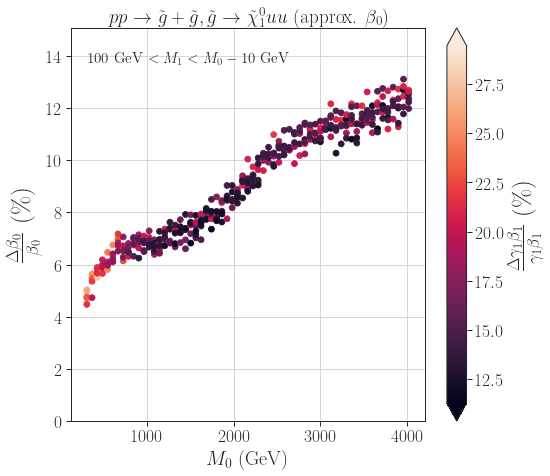

In [10]:
x = dataAna['M0'] # M0
y = 100*np.abs(dataAna['b_0']-data['b_0'])/data['b_0']
z = 100*np.abs(dataAna['gb_1']-data['gb_1'])/data['gb_1']

xlabel = r'$M_0$ (GeV)'
ylabel = r'$\frac{\Delta \beta_0}{\beta_0}$ (\%)'
zlabel = r'$\frac{\Delta \gamma_1 \beta_1}{\gamma_1 \beta_1}$ (\%)'
title = processLatexLabels[process]+ r' (approx. $\beta_0$)'
diffM = dataAna['M0']-dataAna['M1']
text = r'%1.0f GeV $< M_1 < M_0 - %1.0f$ GeV' %(dataAna['M1'].min(),diffM.min())

plt.scatter(x,y,c=z,s=35)
cb = plt.colorbar(extend='both')
cb.set_label(label=zlabel,fontsize=25)
plt.xlabel(xlabel,fontsize=20)
plt.ylabel(ylabel,fontsize=25)
plt.title(title)
plt.text(1.05*min(x),1.05*max(y),text,fontsize=15)
plt.ylim(0,1.15*y.max())

plt.grid(True)
plt.tight_layout()
figname = processShortLabels[madGraphOutput]+'.png'

ff = plt.savefig(figname, format='png')
plt.show()

In [11]:
z = np.abs(dataAnaP['gb_1']-data['gb_1'])/data['gb_1']
imax = np.argmax(z)
print(imax,dataAna['gb_1'][imax],dataAna['M0'][imax],dataAna['M1'][imax])
print(imax,data['gb_1'][imax],data['M0'][imax],data['M1'][imax])

355 2.0007 3840 846
355 1.63925 3840.0 846.0


In [12]:
print( getAvgGammaBeta(Ms=[(3480.,0),(100.,(3480-100)/2.)],beta0Process='VANA',computeStd=False))

[[ 0.5165387  0.       ]
 [14.9455     0.       ]]


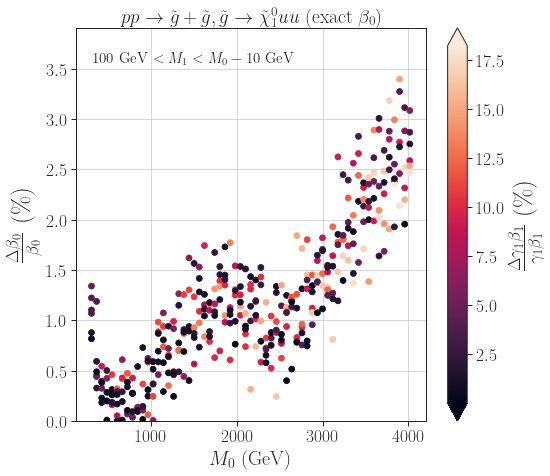

In [13]:
x = dataAnaP['M0'] # M0
y = 100*np.abs(dataAnaP['b_0']-data['b_0'])/data['b_0']
z = 100*np.abs(dataAnaP['gb_1']-data['gb_1'])/data['gb_1']

xlabel = r'$M_0$ (GeV)'
ylabel = r'$\frac{\Delta \beta_0}{\beta_0}$ (\%)'
zlabel = r'$\frac{\Delta \gamma_1 \beta_1}{\gamma_1 \beta_1}$ (\%)'
title = processLatexLabels[process]+ r' (exact $\beta_0$)'
diffM = dataAna['M0']-dataAna['M1']
text = r'%1.0f GeV $< M_1 < M_0 - %1.0f$ GeV' %(dataAna['M1'].min(),diffM.min())

plt.scatter(x,y,c=z,s=35)
cb = plt.colorbar(extend='both')
cb.set_label(label=zlabel,fontsize=25)
plt.xlabel(xlabel,fontsize=20)
plt.ylabel(ylabel,fontsize=25)
plt.title(title)
plt.text(1.05*min(x),1.05*max(y),text,fontsize=15)
plt.ylim(0,1.15*y.max())

plt.grid(True)
plt.tight_layout()

figname = processShortLabels[madGraphOutput]+'_exact.png'

ff = plt.savefig(figname, format='png')
plt.show()

### Second Decay (if available)

In [14]:
if 'gb_2' in dataAna.columns and 'M2' in dataAna.columns:
    x = dataAna['M1'] # M1
    y = 100*np.abs(dataAna['b_1']-data['b_1'])/data['b_1']
    z = 100*np.abs(dataAna['gb_2']-data['gb_2'])/data['gb_2']

    xlabel = r'$M_1$ (GeV)'
    ylabel = r'$\frac{\Delta \beta_1}{\beta_1}$ (\%)'
    zlabel = r'$\frac{\Delta \gamma_2 \beta_2}{\gamma_2 \beta_2}$ (\%)'
    title = processLatexLabels[process]+ r' (approx. $\beta_0$)'
    diffM = dataAna['M1']-dataAna['M2']
    text = r'%1.0f GeV $< M_2 < M_1 - %1.0f$ GeV' %(dataAna['M2'].min(),diffM.min())

    plt.scatter(x,y,c=z,s=35)
    cb = plt.colorbar(extend='both')
    cb.set_label(label=zlabel,fontsize=25)
    plt.xlabel(xlabel,fontsize=20)
    plt.ylabel(ylabel,fontsize=25)
    plt.title(title)
    plt.text(1.05*min(x),1.05*max(y),text,fontsize=15)
    plt.ylim(0,1.15*y.max())

    plt.grid(True)
    plt.tight_layout()
    figname = processShortLabels[madGraphOutput]+'_2ndDecay.png'

    ff = plt.savefig(figname, format='png')
    plt.show()

In [15]:
if 'gb_2' in dataAna.columns and 'M2' in dataAna.columns:
    x = dataAna['M1'] # M1
    y = 100*np.abs(dataAnaP['b_1']-data['b_1'])/data['b_1']
    z = 100*np.abs(dataAnaP['gb_2']-data['gb_2'])/data['gb_2']

    xlabel = r'$M_1$ (GeV)'
    ylabel = r'$\frac{\Delta \beta_1}{\beta_1}$ (\%)'
    zlabel = r'$\frac{\Delta \gamma_2 \beta_2}{\gamma_2 \beta_2}$ (\%)'
    title = processLatexLabels[process]+ r' (exact $\beta_0$)'
    diffM = dataAna['M1']-dataAna['M2']
    text = r'%1.0f GeV $< M_2 < M_1 - %1.0f$ GeV' %(dataAna['M2'].min(),diffM.min())

    plt.scatter(x,y,c=z,s=35)
    cb = plt.colorbar(extend='both')
    cb.set_label(label=zlabel,fontsize=25)
    plt.xlabel(xlabel,fontsize=20)
    plt.ylabel(ylabel,fontsize=25)
    plt.title(title)
    plt.text(1.05*min(x),1.05*max(y),text,fontsize=15)
    plt.ylim(0,1.15*y.max())

    plt.grid(True)
    plt.tight_layout()
    figname = processShortLabels[madGraphOutput]+'_2ndDecay_exact.png'

    ff = plt.savefig(figname, format='png')
    plt.show()

### Plot beta values

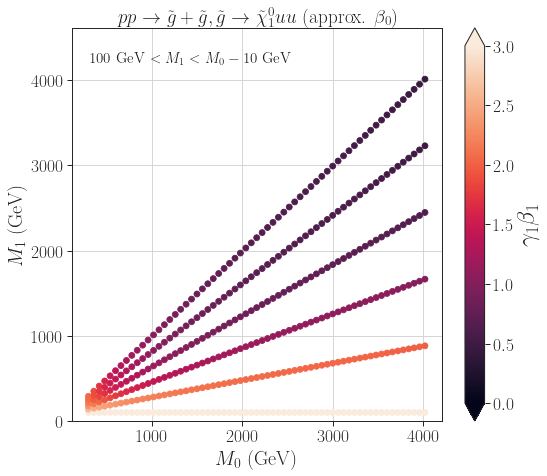

In [16]:
x = dataAna['M0']
y = dataAna['M1']
z = dataAna['gb_1']

xlabel = r'$M_0$ (GeV)'
ylabel = r'$M_1$ (GeV)'
zlabel = r'$\gamma_1 \beta_1$'
title = processLatexLabels[process]+ r' (approx. $\beta_0$)'
diffM = dataAna['M0']-dataAna['M1']
text = r'%1.0f GeV $< M_1 < M_0 - %1.0f$ GeV' %(dataAna['M1'].min(),diffM.min())

plt.scatter(x,y,c=z,s=35,vmin=0.,vmax=3.0)
cb = plt.colorbar(extend='both')
cb.set_label(label=zlabel,fontsize=25)
plt.xlabel(xlabel,fontsize=20)
plt.ylabel(ylabel,fontsize=20)
plt.title(title)
plt.text(1.05*min(x),1.05*max(y),text,fontsize=15)
plt.ylim(0,1.15*y.max())

plt.grid(True)
plt.tight_layout()
figname = processShortLabels[madGraphOutput]+'_gb1.png'

ff = plt.savefig(figname, format='png')
plt.show()

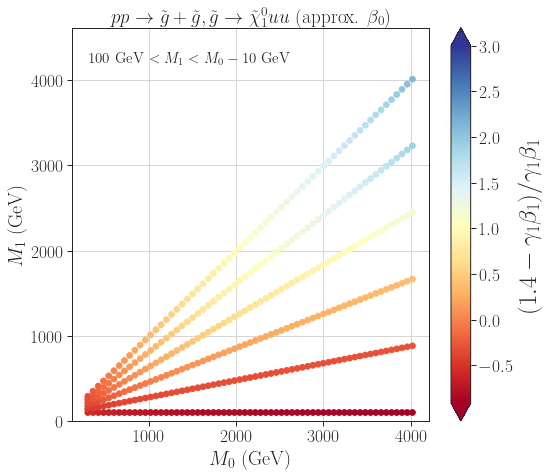

In [17]:
x = dataAna['M0']
y = dataAna['M1']
z = (1.4-dataAna['gb_1'])/dataAna['gb_1']

xlabel = r'$M_0$ (GeV)'
ylabel = r'$M_1$ (GeV)'
zlabel = r'$(1.4-\gamma_1 \beta_1)/\gamma_1 \beta_1$'
title = processLatexLabels[process]+ r' (approx. $\beta_0$)'
diffM = dataAna['M0']-dataAna['M1']
text = r'%1.0f GeV $< M_1 < M_0 - %1.0f$ GeV' %(dataAna['M1'].min(),diffM.min())

plt.scatter(x,y,c=z,s=35,vmin=z.min(),vmax=3.0,cmap=cm)
cb = plt.colorbar(extend='both')
cb.set_label(label=zlabel,fontsize=25)
plt.xlabel(xlabel,fontsize=20)
plt.ylabel(ylabel,fontsize=20)
plt.title(title)
plt.text(1.05*min(x),1.05*max(y),text,fontsize=15)
plt.ylim(0,1.15*y.max())

plt.grid(True)
plt.tight_layout()
figname = processShortLabels[madGraphOutput]+'_gb1.png'

ff = plt.savefig(figname, format='png')
plt.show()

In [18]:
if 'gb_2' in dataAna.columns and 'M2' in dataAna.columns:
    x = dataAna['M1']
    y = dataAna['M2']
    z = dataAna['gb_2']

    xlabel = r'$M_1$ (GeV)'
    ylabel = r'$M_2$ (GeV)'
    zlabel = r'$\gamma_2 \beta_2$'
    title = processLatexLabels[process]+ r' (approx. $\beta_0$)'
    diffM = dataAna['M1']-dataAna['M2']
    text = r'%1.0f GeV $< M_2 < M_1 - %1.0f$ GeV' %(dataAna['M2'].min(),diffM.min())

    plt.scatter(x,y,c=z,s=35,vmin=0.,vmax=3.0)
    cb = plt.colorbar(extend='both')
    cb.set_label(label=zlabel,fontsize=25)
    plt.xlabel(xlabel,fontsize=20)
    plt.ylabel(ylabel,fontsize=20)
    plt.title(title)
    plt.text(1.05*min(x),1.05*max(y),text,fontsize=15)
    plt.ylim(0,1.15*y.max())

    plt.grid(True)
    plt.tight_layout()
    figname = processShortLabels[madGraphOutput]+'_gb2.png'

    ff = plt.savefig(figname, format='png')
    plt.show()

In [19]:
if 'gb_2' in dataAna.columns and 'M2' in dataAna.columns:
    x = dataAna['M1']
    y = dataAna['M2']
    z = (1.4-dataAna['gb_2'])/dataAna['gb_2']

    xlabel = r'$M_1$ (GeV)'
    ylabel = r'$M_2$ (GeV)'
    zlabel = r'$(1.4-\gamma_2 \beta_2)/\gamma_2 \beta_2$'
    title = processLatexLabels[process]+ r' (approx. $\beta_0$)'
    diffM = dataAna['M1']-dataAna['M2']
    text = r'%1.0f GeV $< M_2 < M_1 - %1.0f$ GeV' %(dataAna['M2'].min(),diffM.min())

    plt.scatter(x,y,c=z,s=35,vmin=z.min(),vmax=3.0,cmap=cm)
    cb = plt.colorbar(extend='both')
    cb.set_label(label=zlabel,fontsize=25)
    plt.xlabel(xlabel,fontsize=20)
    plt.ylabel(ylabel,fontsize=20)
    plt.title(title)
    plt.text(1.05*min(x),1.05*max(y),text,fontsize=15)
    plt.ylim(0,1.15*y.max())

    plt.grid(True)
    plt.tight_layout()
    figname = processShortLabels[madGraphOutput]+'_gb2.png'

    ff = plt.savefig(figname, format='png')
    plt.show()